# Data Analysis
### Predictive modelling of stroke occurences

Import libraries

In [1]:
import pandas as pd
from utils import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

Load data

In [2]:
data_loader = DataLoader("healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

# Preprocess data
- Using the preprocessing pipeline from Utils based on the findings from the data exploration 
- Oversample to account for the imbalance in the data set

In [3]:
data_loader.preprocess_data()
# Split the data for testing and training
X_train, X_test, y_train, y_test, X_val, y_val = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

# Oversample the train data 
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

(2682, 20)
(1533, 20)
After oversampling: (5114, 20)


In [4]:
X_train

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,67.0,0.0,1.0,97.24,28.1
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,62.0,0.0,0.0,82.57,27.5
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,48.0,1.0,0.0,83.34,49.3
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,76.81,28.3
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,38.0,0.0,0.0,71.06,22.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,83.24,26.3
5110,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,80.0,1.0,0.0,91.02,32.9
5111,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,82.0,0.0,0.0,59.32,33.2
5112,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,81.0,0.0,0.0,80.13,23.4


## Fit models
- ANN
- Random Forest
- XGBoost

### ANN

In [5]:
#Scale and Fit the data
# Scaling is needed which it is not for random forest or XGBoost
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(.6))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dropout(.6))
#model.add(Dense(units = 5, activation = 'relu'))
#model.add(Dropout(.4))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = 'accuracy')

In [8]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [9]:
#Fitting model
model.fit(X_train, y_train, 
          epochs = 100,
         validation_data=(X_val, y_val),
         verbose = 1, 
         callbacks=callbacks, batch_size=10)

Epoch 1/100
512/512 [==============================] - 2s 3ms/step - loss: 0.6968 - accuracy: 0.4861 - val_loss: 0.8128 - val_accuracy: 0.0548
Epoch 2/100
512/512 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5045 - val_loss: 1.1331 - val_accuracy: 0.0548
Epoch 3/100
512/512 [==============================] - 1s 2ms/step - loss: 0.6925 - accuracy: 0.5049 - val_loss: 0.4018 - val_accuracy: 0.9452
Epoch 4/100
512/512 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5051 - val_loss: 2.0890 - val_accuracy: 0.0548
Epoch 5/100
512/512 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.5066 - val_loss: 1.3000 - val_accuracy: 0.0548
Epoch 6/100
512/512 [==============================] - 1s 2ms/step - loss: 0.6895 - accuracy: 0.5123 - val_loss: 0.7488 - val_accuracy: 0.0548
Epoch 7/100
512/512 [==============================] - 1s 3ms/step - loss: 0.6908 - accuracy: 0.5084 - val_loss: 0.8362 - val_accuracy: 0.0548

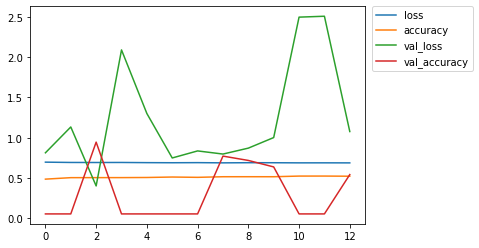

In [10]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [19]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test)
# Convert into classes 
prediction_best = []
for i in prediction_values:
    prediction_best.append(np.where(i > 0.5, 1,0)[0])

print(f"F1 Score {f1_score(y_test, prediction_best, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction_best)}")

train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print(train_acc, test_acc)

48/48 [==============================] - 0s 2ms/step
F1 Score 0.5415088887875056
Accuracy 0.8845401174168297
[0.69243323802948, 0.5164254903793335] [0.6776678562164307, 0.8845401406288147]


In [12]:
#Predictions
prediction_values = model.predict(X_test)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])
    

48/48 [==============================] - 0s 2ms/step


In [17]:
# Prediction on the last model not the best
print(f"F1 Score {f1_score(y_test, prediction, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction)}")

F1 Score 0.5354289914936815
Accuracy 0.8023483365949119


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,prediction_best))
print()
cf = confusion_matrix(y_test,prediction_best)
print(cf)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1458
           1       0.11      0.20      0.14        75

    accuracy                           0.88      1533
   macro avg       0.54      0.56      0.54      1533
weighted avg       0.92      0.88      0.90      1533


[[1341  117]
 [  60   15]]


<AxesSubplot:>

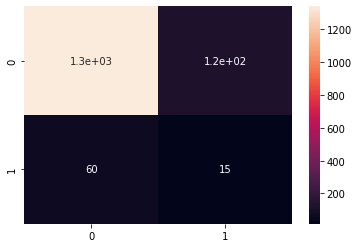

In [21]:
import seaborn as sns
sns.heatmap(cf, annot=True)

### XGBoost

In [22]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'error')
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
print(cf)

F1 Score 0.5541095890410959
Accuracy 0.9191128506196999
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1458
           1       0.15      0.15      0.15        75

    accuracy                           0.92      1533
   macro avg       0.56      0.55      0.55      1533
weighted avg       0.92      0.92      0.92      1533


[[1398   60]
 [  64   11]]


<AxesSubplot:>

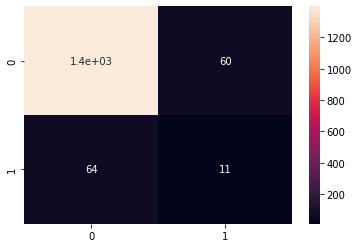

In [23]:
sns.heatmap(cf, annot = True)

### Random Forest

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)

F1 Score 0.5053451178451178
Accuracy 0.9399869536855838
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.10      0.03      0.04        75

    accuracy                           0.94      1533
   macro avg       0.52      0.51      0.51      1533
weighted avg       0.91      0.94      0.92      1533




<AxesSubplot:>

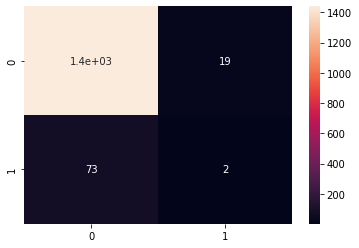

In [25]:
sns.heatmap(cf, annot = True)